In [2306]:
! pip install sklearn-pandas
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# For preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper 

import torch # For building the networks 
import torchtuples as tt # Some useful functions
# change pycox import datasets and df= read.csv

df_train=pd.read_csv('D:/UNOS_NEW/have_dephit_train_cindex.csv', sep=',')
df_test=pd.read_csv('D:/UNOS_NEW/have_dephit_test_cindex.csv', sep=',')
df_val=pd.read_csv('D:/UNOS_NEW/have_dephit_val_cindex.csv', sep=',')
from pycox.models import DeepHitSingle
from pycox.evaluation import EvalSurv
## Uncomment to install `sklearn-pandas`
# ! pip install sklearn-pandas
np.random.seed(1234)
_ = torch.manual_seed(123)


df_train['TX_YEAR']=df_train['TX_YEAR'].astype('float32')
df_train['TBILI_TX']=df_train['TBILI_TX'].astype('float32')
df_train['ALBUMIN_TX']=df_train['ALBUMIN_TX'].astype('float32')
df_train['CMV_STATUS']=df_train['CMV_STATUS'].astype('float32')
df_train['COLD_ISCH']=df_train['COLD_ISCH'].astype('float32')
df_train['CREAT_TX']=df_train['CREAT_TX'].astype('float32')
df_train['ETHCAT_DON']=df_train['ETHCAT_DON'].astype('float32')
df_train['FINAL_INR']=df_train['FINAL_INR'].astype('float32')
df_train['AGE']=df_train['AGE'].astype('float32')
df_train['ETHCAT']=df_train['ETHCAT'].astype('float32')
df_train['duration']=df_train['duration'].astype('float32')
df_train['event']=df_train['event'].astype('int32')


df_test['TX_YEAR']=df_test['TX_YEAR'].astype('float32')
df_test['TBILI_TX']=df_test['TBILI_TX'].astype('float32')
df_test['ALBUMIN_TX']=df_test['ALBUMIN_TX'].astype('float32')
df_test['CMV_STATUS']=df_test['CMV_STATUS'].astype('float32')
df_test['COLD_ISCH']=df_test['COLD_ISCH'].astype('float32')
df_test['CREAT_TX']=df_test['CREAT_TX'].astype('float32')
df_test['ETHCAT_DON']=df_test['ETHCAT_DON'].astype('float32')
df_test['FINAL_INR']=df_test['FINAL_INR'].astype('float32')
df_test['AGE']=df_test['AGE'].astype('float32')
df_test['ETHCAT']=df_test['ETHCAT'].astype('float32')
df_test['duration']=df_test['duration'].astype('float32')
df_test['event']=df_test['event'].astype('int32')

df_val['TX_YEAR']=df_val['TX_YEAR'].astype('float32')
df_val['TBILI_TX']=df_val['TBILI_TX'].astype('float32')
df_val['ALBUMIN_TX']=df_val['ALBUMIN_TX'].astype('float32')
df_val['CMV_STATUS']=df_val['CMV_STATUS'].astype('float32')
df_val['COLD_ISCH']=df_val['COLD_ISCH'].astype('float32')
df_val['CREAT_TX']=df_val['CREAT_TX'].astype('float32')
df_val['ETHCAT_DON']=df_val['ETHCAT_DON'].astype('float32')
df_val['FINAL_INR']=df_val['FINAL_INR'].astype('float32')
df_val['AGE']=df_val['AGE'].astype('float32')
df_val['ETHCAT']=df_val['ETHCAT'].astype('float32')
df_val['duration']=df_val['duration'].astype('float32')
df_val['event']=df_val['event'].astype('int32')

In [2307]:
import numpy as np
import pandas as pd

class OrderedCategoricalLong:
    """Transform pandas series or numpy array to categorical, and get (long) values,
    i.e. index of category. Useful for entity embeddings.
    Zero is reserved for unknown categories or nans.
    Keyword Arguments:
        min_per_category {int} -- Number of instances required to not be set to nan (default: {20})
        return_series {bool} -- If return a array or pd.Series (default: {False})
    
    Returns:
        [pd.Series] -- Series with long values reffering to categories.
    """
    def __init__(self, min_per_category=20, return_series=False):
        
        self.min_per_category = min_per_category
        self.return_series = return_series

    def fit(self, series, y=None):
        series = pd.Series(series).copy()
        smaller = series.value_counts() < self.min_per_category
        values = smaller[smaller].index.values
        for v in values:
            series[series == v] = np.nan
        self.categories = series.astype('category').cat.categories
        return self
    
    def transform(self, series, y=None):
        series = pd.Series(series).copy()
        transformed = pd.Categorical(series, categories=self.categories, ordered=True)
        transformed = pd.Series(transformed, index=series.index)
        transformed = transformed.cat.codes.astype('int64') + 1
        return transformed if self.return_series else transformed.values
    
    def fit_transform(self, series, y=None):
        return self.fit(series, y).transform(series, y)
cols_std = ['TBILI_TX','ALBUMIN_TX','COLD_ISCH', 'CREAT_TX','FINAL_INR','AGE'] # numeric variables
cols_cat = ['TX_YEAR','CMV_STATUS','ETHCAT_DON','ETHCAT'] # categorical variables


standardize = [([col], StandardScaler()) for col in cols_std]
categorical = [(col, OrderedCategoricalLong()) for col in cols_cat]

x_mapper_float = DataFrameMapper(standardize)
x_mapper_long = DataFrameMapper(categorical)  # we need a separate mapper to convert data to 'int64'

x_fit_transform = lambda df: tt.tuplefy(x_mapper_float.fit_transform(df), x_mapper_long.fit_transform(df))
x_transform = lambda df: tt.tuplefy(x_mapper_float.transform(df), x_mapper_long.transform(df))

x_train = x_fit_transform(df_train)
x_val = x_transform(df_val)
x_test = x_transform(df_test)

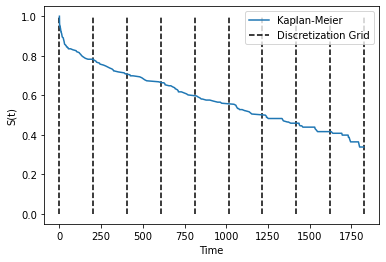

In [2308]:
num_durations = 10
scheme = 'equidistant' # or quantiles
labtrans = DeepHitSingle.label_transform(num_durations, scheme)
get_target = lambda df: (df['duration'].values, df['event'].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))

train = (x_train, y_train)
val = (x_val, y_val)

# We don't need to transform the test labels
durations_test, events_test = get_target(df_test)

# Plotting discrete intervals
from pycox.utils import kaplan_meier
plt.vlines(labtrans.cuts, 0, 1, colors='black', linestyles="--", label='Discretization Grid')
kaplan_meier(*get_target(df_train)).plot(label='Kaplan-Meier')
plt.ylabel('S(t)')
plt.legend()
_ = plt.xlabel('Time')

In [2309]:
num_embeddings = x_train[1].max(0) + 1
embedding_dims = num_embeddings // 2

in_features = x_train[0].shape[1]
out_features = labtrans.out_features
num_nodes = [64, 32]
batch_norm = True
dropout = 0.7

net = tt.practical.MixedInputMLP(in_features, num_embeddings, embedding_dims,
                                 num_nodes, out_features, batch_norm, dropout)
                                 
optimizer = tt.optim.AdamWR(decoupled_weight_decay=0.01, cycle_eta_multiplier=0.8,
                            cycle_multiplier=2)

model = DeepHitSingle(net, optimizer, duration_index=labtrans.cuts)

In [2310]:
batch_size =1500
lrfind = model.lr_finder(x_train, y_train, batch_size, tolerance=50)
lrfind.get_best_lr()

0.1873817422860396

In [2311]:
model.optimizer.set_lr(0.187)

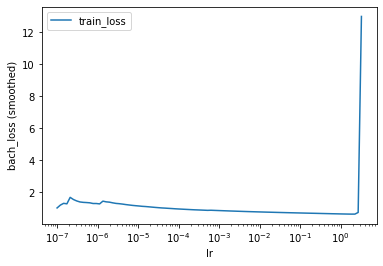

In [2312]:
_=lrfind.plot()

In [2313]:
epochs = 100
callbacks = [tt.cb.EarlyStoppingCycle()]
verbose = True 

log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val)

0:	[0s / 0s],		train_loss: 1.9331,	val_loss: 11.5259
1:	[0s / 0s],		train_loss: 7.5589,	val_loss: 13.7095
2:	[0s / 0s],		train_loss: 5.0437,	val_loss: 4.1798
3:	[0s / 0s],		train_loss: 7.2965,	val_loss: 0.9219
4:	[0s / 0s],		train_loss: 4.5630,	val_loss: 0.7890
5:	[0s / 0s],		train_loss: 1.7521,	val_loss: 0.6697
6:	[0s / 0s],		train_loss: 1.4335,	val_loss: 0.6265
7:	[0s / 0s],		train_loss: 1.9947,	val_loss: 0.6119
8:	[0s / 0s],		train_loss: 1.6454,	val_loss: 0.5839
9:	[0s / 0s],		train_loss: 1.5280,	val_loss: 0.5655
10:	[0s / 0s],		train_loss: 1.0291,	val_loss: 0.5578
11:	[0s / 0s],		train_loss: 1.4583,	val_loss: 0.5496
12:	[0s / 0s],		train_loss: 2.0310,	val_loss: 0.5472
13:	[0s / 0s],		train_loss: 1.1623,	val_loss: 0.5454
14:	[0s / 0s],		train_loss: 1.0927,	val_loss: 0.5427
15:	[0s / 0s],		train_loss: 1.3568,	val_loss: 0.5339
16:	[0s / 0s],		train_loss: 0.9682,	val_loss: 0.5306
17:	[0s / 0s],		train_loss: 0.9740,	val_loss: 0.5179
18:	[0s / 0s],		train_loss: 0.9548,	val_loss: 0.5101
1

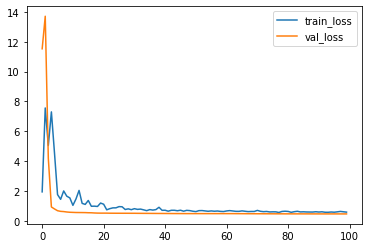

In [2314]:
_ = log.plot()

In [2315]:
surv = model.predict_surv_df(x_test)

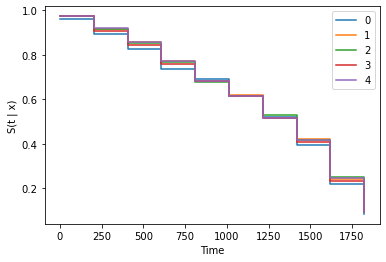

In [2316]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [2317]:
surv = model.interpolate(10).predict_surv_df(x_test)

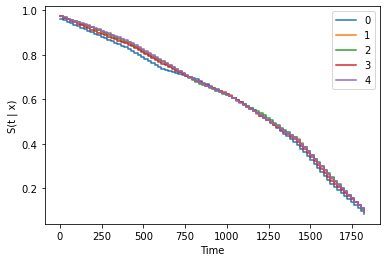

In [2318]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [2319]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

In [2320]:
ev.concordance_td('antolini')

0.7863636363636364

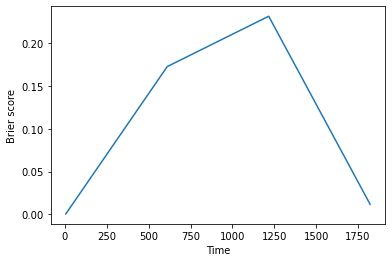

In [2372]:
time_grid = np.linspace(durations_test.min(), durations_test.max(),4)
ev.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

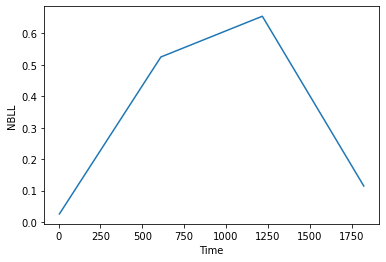

In [2373]:
ev.nbll(time_grid).plot()
plt.ylabel('NBLL')
_ = plt.xlabel('Time')

In [2374]:
ev.integrated_brier_score(time_grid) 

0.14739079332576357

In [2375]:
ev.integrated_nbll(time_grid) 

0.4453589763547928

In [493]:
%history

! pip install sklearn-pandas
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# For preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper 

import torch # For building the networks 
import torchtuples as tt # Some useful functions
# change pycox import datasets and df= read.csv

df_train=pd.read_csv('D:/UNOS_NEW/have_dephit_train_cindex.csv', sep=',')
df_test=pd.read_csv('D:/UNOS_NEW/have_dephit_test_cindex.csv', sep=',')
df_val=pd.read_csv('D:/UNOS_NEW/have_dephit_val_cindex.csv', sep=',')
from pycox.models import DeepHitSingle
from pycox.evaluation import EvalSurv
## Uncomment to install `sklearn-pandas`
# ! pip install sklearn-pandas
np.random.seed(1234)
_ = torch.manual_seed(123)

df_train['DAYSWAIT_CHRON']=df_train['DAYSWAIT_CHRON'].astype('float32')
df_train['TX_YEAR']=df_train['TX_YEAR'].astype('float32')
df_train['AGE']=df_train['AGE'].astype('float32')
df_train['ETHCAT']=df_train['ETHCAT'].astype('float3